In [211]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from math import pi

from scipy.interpolate import interp1d
from scipy.optimize import curve_fit, brentq, fsolve, least_squares
from scipy.integrate import quad, simpson, solve_ivp
from scipy.special import zeta
from scipy.sparse import csr_matrix

from tqdm import tqdm

# plt.rcParams['font.family'] = 'Times New Roman'
# plt.rcParams['mathtext.fontset'] = 'stix'#['dejavusans', 'dejavuserif', 'cm', 'stix', 'stixsans', 'custom']
# font = {'family': 'Times New Roman',
#         #'color':  'black',
#         'weight': 'normal',
#         'size': 14,
#         }

In [2]:
# aesthetic definitions for the plots
# font = {'size'   : 16, 'family':'STIXGeneral'}
# axislabelfontsize='large'
# matplotlib.rc('font', **font)
# matplotlib.mathtext.rcParams['legend.fontsize']='medium'
# plt.rcParams["figure.figsize"] = [8.0,6.0]

# %config InlineBackend.figure_format = "retina"
# plt.rcParams['figure.figsize'] = (13, 8)
# plt.rcParams['font.family'] = 'STIXGeneral'
# matplotlib.mathtext.rcParams['legend.fontsize']='medium'
# plt.rcParams['font.serif'] = ['New Times Roman']
# # plt.rc('text', usetex=True)

# 0. Preamble

## 0.1 Definitions, Constants, and Parameters

Natural Units:

In [3]:
eV = 1.e-9
keV = 1.e-6
MeV = 1.e-3
GeV = 1.
TeV = 1.e3

SI Units (and others):

In [4]:
Kelvin = (8.61734231196981e-5)*eV
sec = (1.519268e21)/MeV
yr = (3.15576e7)*sec
gr = (5.609589e23)*GeV
mtr = (5.067731e15)/GeV
km = 1000*mtr
cm = 0.01*mtr
Mpc = (3.08567758128e19)*km

Useful cosmological parameters and constants:

In [5]:
Mpl = (1.22091e19) * GeV
mpl = Mpl/np.sqrt(8.*pi)
MGUT = 1.e15 * GeV

In [6]:
h = 0.6766
rho_crit = 3.* mpl**2 * (100.*h * km/sec / Mpc)**2
H0 = np.sqrt(rho_crit / (3. * mpl**2))

In [7]:
T_g0 = 2.7255*Kelvin
# gs0 = 3.94
gs0 = 3.909 # arXiv:1609.04979, Table 2
# ge0 = 3.38
ge0 = 3.363 # arXiv:1609.04979, Table 2
ge_1nu = 2.*(7./8.)*(4./11.)**(4./3.)
gSM = 106.75

ncoeff = zeta(3.)/(pi**2)
ffn = 3./4.

rho_coeff = (pi**2.)/ 30.
ffrho = 7./8.

scoeff = 2.*pi**2 / 45.
ffs = ffrho

s0tot = gs0*scoeff*T_g0**3.
nsRatio = ncoeff/scoeff

In [8]:
Omega_b = 0.02242/h**2
Omega_dm = 0.11933/h**2
Omega_m = Omega_b + Omega_dm

Useful particle physics constants and parameters:

In [9]:
vEW = 246.*GeV
mh = 125.25*GeV
mZ = 91.19*GeV
mW = 80.377*GeV

mu, md, ms, mc, mb, mt = 2.16*MeV, 4.67*MeV, 93.4*MeV, 1.27*GeV, 4.18*GeV, 172.69*GeV

mp = 938.2720813*MeV
mn = 939.5654133*MeV
mpi = 134.9768*MeV
fpi = 92.*MeV
me = 0.51099895*MeV

zud = mu/md
zp = zud/(1 + zud)**2

Tcrit = 150.*MeV

alpha_em = 0.00729735253

## 0.2 Important Functions

### 0.2.a $\rho_{\rm rad}(g_{*e}, T)$, and $H(\rho)$

In [10]:
def rho_rad(gse, Temp):
    """
    rho_rad : radiation energy density [GeV^4].

    Parameters:
    gse : relativistic d.o.f. in entropy
    Temp : temperature [GeV]

    Returns:
    rho_rad [GeV^4]
    """

    return rho_coeff * gse * Temp**4

def Hubble(rho):
    """
    Hubble : Hubble expansion rate [GeV].

    Parameters:
    rho : energy density [GeV^4]

    Returns:
    Hubble [GeV]
    """

    return np.sqrt( rho/ (3. * mpl**2.))

### 0.2.b $g_{*s}(T)$

Obtaining $\ g_{*s}(T \text{ [GeV]})$ table from data file:

In [11]:
# gs_data = np.genfromtxt('./data/entropy_dof_old.csv', delimiter=',')
gs_data = np.genfromtxt('./data/entropy_dof.csv', delimiter=',')[::-1]
gs_data

array([[1.00000000e-05, 3.90900000e+00],
       [1.97918150e-05, 3.90900000e+00],
       [3.44144802e-05, 3.90900000e+00],
       [5.25734858e-05, 3.92236845e+00],
       [6.65278050e-05, 4.04065353e+00],
       [9.35935685e-05, 4.57767716e+00],
       [1.30129870e-04, 5.66954735e+00],
       [1.83071107e-04, 7.10579875e+00],
       [2.69966517e-04, 8.59396436e+00],
       [4.32297524e-04, 9.73614643e+00],
       [7.17118711e-04, 1.03322177e+01],
       [1.23235214e-03, 1.05807421e+01],
       [2.27273877e-03, 1.06438017e+01],
       [3.90564972e-03, 1.07072371e+01],
       [6.87164481e-03, 1.07072371e+01],
       [1.18087648e-02, 1.07072371e+01],
       [2.05333620e-02, 1.12285216e+01],
       [3.36632893e-02, 1.27208499e+01],
       [5.45432754e-02, 1.45838090e+01],
       [8.73401749e-02, 1.66205412e+01],
       [1.27289427e-01, 2.03416931e+01],
       [1.50092098e-01, 2.46018486e+01],
       [1.70839330e-01, 3.01099253e+01],
       [1.79075076e-01, 3.35089863e+01],
       [1.967567

Taking the $\log_{10}$ of the x-axis (i.e., the temperature):

In [12]:
gs_Lxydata = np.array([np.log10(gs_data[:,0]), gs_data[:,1]]).transpose()
gs_Lxydata

array([[-5.00000000e+00,  3.90900000e+00],
       [-4.70351438e+00,  3.90900000e+00],
       [-4.46325879e+00,  3.90900000e+00],
       [-4.27923323e+00,  3.92236845e+00],
       [-4.17699681e+00,  4.04065353e+00],
       [-4.02875399e+00,  4.57767716e+00],
       [-3.88562300e+00,  5.66954735e+00],
       [-3.73738019e+00,  7.10579875e+00],
       [-3.56869010e+00,  8.59396436e+00],
       [-3.36421725e+00,  9.73614643e+00],
       [-3.14440895e+00,  1.03322177e+01],
       [-2.90926518e+00,  1.05807421e+01],
       [-2.64345048e+00,  1.06438017e+01],
       [-2.40830671e+00,  1.07072371e+01],
       [-2.16293930e+00,  1.07072371e+01],
       [-1.92779553e+00,  1.07072371e+01],
       [-1.68753994e+00,  1.12285216e+01],
       [-1.47284345e+00,  1.27208499e+01],
       [-1.26325879e+00,  1.45838090e+01],
       [-1.05878594e+00,  1.66205412e+01],
       [-8.95207668e-01,  2.03416931e+01],
       [-8.23642173e-01,  2.46018486e+01],
       [-7.67412141e-01,  3.01099253e+01],
       [-7.

Interpolating the resulting grid:

In [13]:
gs_fnLxy = interp1d(gs_Lxydata[:,0], gs_Lxydata[:,1], bounds_error=False)

Finally, defining the function $g_{*s}(T \, \text{[GeV]})$ for any temperature:

In [14]:
def gs_fn(Temp):
    """
    gs_fn : function giving the relativistic d.o.f. in entropy.
    
    Parameters:
    Temp : temperature [GeV]

    Returns:
    gs_fn
    """

    Tarr = np.asarray(Temp)

    result = np.where(Tarr <= gs_data[0,0], gs0, np.where(Tarr <= gs_data[-1,0], gs_fnLxy(np.log10(Tarr)), gSM))
    
    if np.isscalar(Temp):
        return result.item()
    else:
        return result

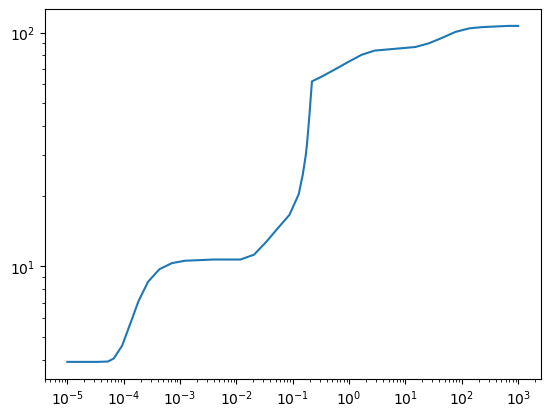

In [15]:
plt.loglog(gs_data[:,0], gs_data[:,1])

### 0.2.c Useful derivatives

Defining $\frac{d \ln g_{*s}}{d \ln T}$:

In [16]:
Thi = 100.*TeV

# Temp_arr = np.logspace(np.log10(T_g0), np.log10(Thi), 10001)
Temp_arr = np.logspace(np.log10(keV), np.log10(Thi), 50001)
gs_arr = np.vectorize(gs_fn)(Temp_arr)

dLgdLT_arr = np.gradient(np.log(gs_arr), np.log(Temp_arr))

From entropy conservation ($S = g_{*s} T^3 a^3 = \text{const.}$) we get:

$\frac{d \ln a}{d \ln T} = -1 - \frac{1}{3} \frac{d \ln g_{*s}}{d \ln T}$

In [17]:
dLadLT_arr = -1. - (1./3.)*dLgdLT_arr

dLadLT_fn = interp1d(np.log(Temp_arr), dLadLT_arr, bounds_error=False)

(-13.0, 0.0)

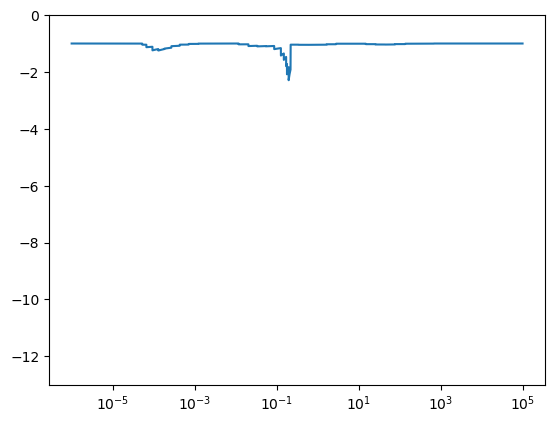

In [18]:
plt.plot(Temp_arr, dLadLT_arr)
plt.xscale('log')
plt.ylim(-13,0)

### 0.2.d $t(T)$

Find the time as a function of the temperature: $\Delta t \equiv t - t_i = \int\limits_{\ln a_i}^{\ln a} \, d \ln a \, \frac{1}{H(T)} = \int\limits_{\ln T_i}^{\ln T} \, d \ln T \, \frac{d \ln a}{d \ln T} \frac{1}{H(T)}$

In [19]:
# def time_fn(Temp, Tini=Thi, limit=100000, epsabs=1.e-6, epsrel=1.e-5):
#     """
#     time_fn : age of the Universe [GeV^-1] and its absolute error for a given temperature, starting from a very high temperature.

#     Parameters:
#     Temp : temperature [GeV]
#     Tini : initial (high) temperature [GeV] (default: Thi)
#     limit : limit of integration steps (default: 100000)
#     epsabs : absolute integration error tolerance (default: 1.e-6)
#     epsrel : relative integration error tolerance (default: 1.e-5)

#     Returns:
#     (time [GeV^-1], abs_error(time) [GeV^-1])
#     """

#     def Hubble_rate(lnT): return Hubble(rho_rad(gs_fn(np.power(np.e, lnT)), np.power(np.e, lnT))) # Hubble expansion rate [GeV] as a function of ln(T)

#     def integrand(lnT): return dLadLT_fn(lnT) / (Hubble_rate(lnT) * (GeV*sec)) # integrand [sec] as a function of ln(T)

#     res, error = quad(lambda lnT: integrand(lnT), np.log(Tini), np.log(Temp), limit=limit, epsabs=epsabs, epsrel=epsrel) # integrating

#     return res*(GeV*sec), error*(GeV*sec) # result in [GeV^-1]

In [20]:
def time_fn(Tini, Tend, **kwargs):
    """
    time_fn : age of the Universe [GeV^-1] and its absolute error for a given temperature, starting from a very high temperature.

    Parameters:
    Temp : temperature [GeV]
    Tini : initial (high) temperature [GeV]
    Tend : final (low) temperature [GeV]

    Returns:
    (time [GeV^-1], abs_error(time) [GeV^-1])
    """

    def Hubble_rate(lnT): return Hubble(rho_rad(gs_fn(np.power(np.e, lnT)), np.power(np.e, lnT))) # Hubble expansion rate [GeV] as a function of ln(T)

    def integrand(lnT): return dLadLT_fn(lnT) / (Hubble_rate(lnT) * (GeV*sec)) # integrand [sec] as a function of ln(T)

    res, error = quad(lambda lnT: integrand(lnT), np.log(Tini), np.log(Tend), **kwargs) # integrating

    return res*(GeV*sec), error*(GeV*sec) # result in [GeV^-1]

Test: the Universe is about 1 sec old at 1 MeV:

In [21]:
print(((time_fn(Thi, MeV, limit=1000, epsabs=1.e-6, epsrel=1.e-4)))[0]/sec, ((time_fn(Thi, 0.85*MeV, limit=1000, epsabs=1.e-6, epsrel=1.e-4)))[0]/sec)

0.7488259943320237 1.040660012146964


Time steps between consecutive temperature values in the temperature array:

*Note*: this has been commented out, since we have already pre-computed the necessary tables, and saved the final result in ./data/

In [22]:
# inv_Temp_arr = Temp_arr[::-1] # note: need to invert Temp_arr so that it goes in decreasing order
# tterr_arr = []

# for i, Tend in tqdm(enumerate(inv_Temp_arr)):
    
#     if i == 0:
#         tterr_arr.append([0., 0.])
    
#     else:
#         Tini = inv_Temp_arr[i-1]

#         def HofT(T): return Hubble(rho_rad(gs_fn(T), T))

#         epsabs = (1.e-5)/(2 * HofT(Tini) * (GeV*sec))
#         epsrel = 1.e-5

#         ti, err_ti = time_fn(Tini, Tend, limit=10000, epsabs=epsabs, epsrel=epsrel)

#         tterr_arr.append([ti, err_ti])

# tterr_arr = np.array(tterr_arr)

# del inv_Temp_arr, i, Tend, Tini, HofT, epsabs, epsrel, ti, err_ti

In [23]:
# print("first 10 steps:\n", tterr_arr[:10])
# print("last 10 steps:\n", tterr_arr[-10:])

The full time array is given by the cumulative sum of these small time intervals:

*Note*: this has been commented out, since the result has been saved in ./data/

In [24]:
# time_arr = np.cumsum(tterr_arr[:,0])
# np.savetxt("./data/time_arr.csv", time_arr, delimiter=",")

In [25]:
time_arr = np.genfromtxt('./data/time_arr.csv', delimiter=',')

In [26]:
time_arr

array([0.00000000e+00, 3.60752666e+04, 7.21871009e+04, ...,
       1.85607895e+30, 1.85796035e+30, 1.85984366e+30])

### 0.2.e $T(t)$:

Inverting $t(T)$:

In [27]:
# interpolating function
# requires reversing the temperature entries (i.e., written them in increasing time), and dropping the first one (for which t=0)

LTLt_fn = interp1d(np.log10(time_arr[1:]), np.log10((Temp_arr[::-1])[1:]), bounds_error=False) # interpolating T(t) in log-space

In [28]:
def T_fn(t):
    """
    T_fn : Temperature [GeV] as a function of the age of the Universe t [GeV^-1].

    Parameters:
    t : time/age of the Universe [GeV^-1]

    Returns:
    T_fn [GeV]
    """

    tarr = np.asarray(t)

    last_t = time_arr[-1]

    res = np.where(tarr > last_t, (10.**LTLt_fn(np.log10(last_t)))*(tarr/last_t)**(-1/2), 10.**LTLt_fn(np.log10(tarr)))

    return res.item() if np.isscalar(t) else res

In [29]:
T_fn(sec)/MeV

0.8668971599727837

The critical time $t_c$ at which $T=T_c$

In [138]:
LTLt_fn2 = lambda Lt: np.abs(LTLt_fn(Lt) - np.log10(Tcrit))
tcrit = (10**fsolve(LTLt_fn2, np.log10(1.e19 * GeV))[0])

print(tcrit, "GeV =", tcrit/sec, "sec")

del LTLt_fn2

3.582299252702877e+19 GeV = 2.357911344609955e-05 sec


Dimensionless $\hat{T}(\hat{t}) \equiv T(\hat{t} \cdot t_c)/T_c$

In [31]:
def T_hat_fn(t_hat):
    """
    T_hat_fn : Temperature in units of Tcrit [dimless] as a function of time t in units of tcrit [dimless].

    Parameters:
    t_hat : time in units of tcrit [dimless]

    Returns:
    T_hat_fn [dimless]
    """

    return T_fn(t_hat*tcrit)/T_fn(tcrit)

In [32]:
time_arr/tcrit

array([0.00000000e+00, 1.00704224e-15, 2.01510527e-15, ...,
       5.18125043e+10, 5.18650235e+10, 5.19175961e+10])

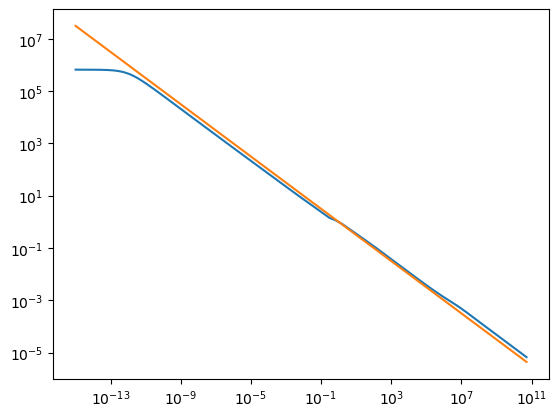

In [33]:
plt.loglog(time_arr[1:]/tcrit, Temp_arr[::-1][1:]/Tcrit)
plt.loglog(time_arr[1:]/tcrit, (time_arr[1:]/tcrit)**(-1/2))

### 0.2.f $H(t)$

In [34]:
def Hubt(t):
    """
    Hubt : Hubble expansion rate [GeV].

    Parameters:
    t : time [GeV^-1]

    Returns:
    Hubt [GeV]
    """

    gs_t = gs_fn(T_fn(t)) # rel. d.o.f. in entropy at the time
    T_t = T_fn(t) # temperature at the time [GeV]

    rho_r_t = rho_rad(gs_t, T_t) # radiation energy density at the time [GeV^4]
    hub_t = Hubble(rho_r_t) # Hubble rate at the time [GeV^-1]

    return hub_t

### 0.2.g $a(t)$

In [35]:
def scale_factor(t):
    """
    scale_factor : scale factor of the Universe [dimless].
     
    Parameters:
    t : time [GeV^-1]

    Returns:
    scale_factor [dimless]
    """

    S0 = gs0 * T_g0**3 # total entropy today

    T_t = T_fn(t) # temperature at the time [GeV]
    gs_t = gs_fn(T_t) # rel. d.o.f. in entropy at the time
    
    a_t = np.power(S0/(gs_t * T_t**3), 1/3)

    return a_t

In [36]:
scale_factor(time_arr[-1]*1.e12)

0.2348656647127372

# 1. Axion Physics

## 1.1 Temperature dependence

Interpolation function of the temperature-dependence of the topological suceptibility, $F(T)$, and its derivative $F'(T)$

In [37]:
def FTemp(T, p=12, small=1.e-6):
    """
    FTemp : ad-hoc interpolation function of the temperature dependence of the topological susceptibility, F(T) [dimless].

    Parameters:
    T : temperature [GeV]
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)

    Returns:
    FTemp [dimless]
    """

    large_value = 1.e20 # a large value

    x = T/Tcrit # ratio of temperature to critical temperature

    xarr = np.asarray(x) # turning argument into array

    den = np.power(1 + np.power(xarr, 8*p), 1./p) # denominator of interpolating function
    den = np.where(den > large_value, large_value, den) # normalizing
    
    func = 1./den # interpolating function

    target = np.where(xarr > 1, 0, 1) # asymptotic target value
    diff = np.abs(target - func) # difference between interpolating function and asymptotic value

    res = np.where(diff < small, target, func)


    return res.item() if np.isscalar(x) else res

/tmp/ipykernel_9154/2125665365.py:20: RuntimeWarning: overflow encountered in power
  den = np.power(1 + np.power(xarr, 8*p), 1./p) # denominator of interpolating function


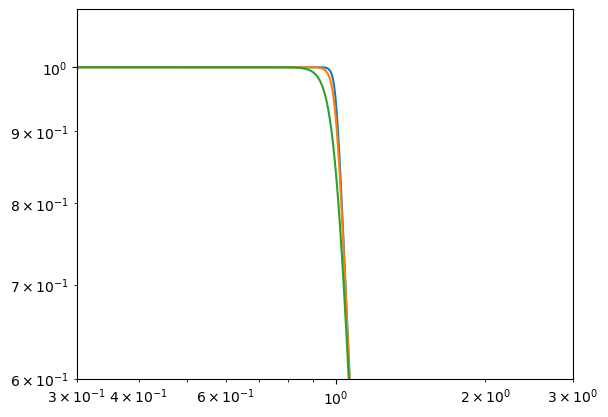

In [38]:
plt.loglog(Temp_arr/Tcrit, FTemp(Temp_arr))
plt.loglog(Temp_arr/Tcrit, FTemp(Temp_arr, 8))
plt.loglog(Temp_arr/Tcrit, FTemp(Temp_arr, 4))

plt.xlim(0.3, 3)
plt.ylim(0.6,1.1);

In [39]:
def dFTdT(T, p=12, small=1.e-6):
    """
    dFTdT : Derivative F'(T) [GeV^-1] of F(T) w.r.t. temperature.

    Parameters:
    T : temperature [GeV]
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)

    Returns:
    dFTdT [GeV^-1]
    """

    x = T/Tcrit # ratio of temperature to critical temperature

    FT = FTemp(T, p, small=small)

    return -8.*np.power(FT*np.power(x,(8.*p)/(1.+p)), 1.+p)/T

## 1.2 Canonical Axion

### 1.2.a Oscillatory part of the potential

$\chi(\theta) \equiv \sqrt{1 + 2z' \left( \cos(\theta) - 1 \right)}$,

where $z' \equiv z/(1+z)^2$.

In [40]:
def chpt_fn(theta):
    """
    chpt_fn : Dependence of the topological susceptibility on the axion angle, obtained from chiral perturbation theory.

    Parameters:
    theta : axion angle [radians]

    Returns:
    chpt_fn [dimless]
    """
    
    return np.sqrt(1. + 2.*zp*( np.cos(theta) - 1. ))

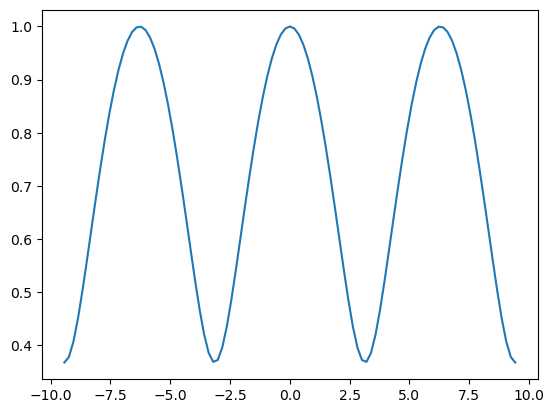

In [41]:
tharr = np.linspace(-3*pi, 3*pi, 101)

plt.plot(tharr, chpt_fn(tharr))

del tharr

### 1.2.b Axion potential from QCD

$V_{\rm QCD}(\theta) = - m_\pi^2 f_\pi^2 \, F(T) \, \chi(\theta)$

In [42]:
def Va_QCD(theta, T=0, p=12, small=1.e-6, cancel_cc=True):
    """
    Va_QCD : axion potential [GeV^4] from QCD, according to leading order in chiral perturbation theory.

    Parameters:
    theta : axion angle [radians]
    T : temperature [GeV] (default: 0)
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)
    cancel_cc : whether we deduct the CC term (default: True)

    Returns:
    Va_QCD [GeV^4]
    """
    
    pref = mpi**2 * fpi**2
    osc = chpt_fn(theta)

    v = -pref*FTemp(T, p=p, small=small)*osc

    if cancel_cc == True:
        v -= -pref
    
    return v

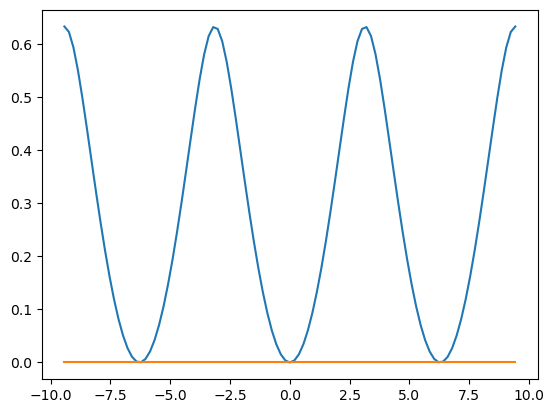

In [43]:
tharr = np.linspace(-3*pi, 3*pi, 101)

plt.plot(tharr, Va_QCD(tharr)/(mpi**2 * fpi**2))
plt.plot(tharr, np.zeros_like(tharr))

del tharr

### 1.2.c Field derivative of QCD axion potential

$V'(\theta) = z' \, m_\pi^2 f_\pi^2 \, F(T) \, \frac{\sin(\theta)}{\chi(\theta)}$

In [44]:
def Va_QCD_prime(theta, T=0, p=12, small=1.e-6):
    """
    Va_QCD_prime : the field derivative of the axion QCD potential [GeV^4].

    Parameters:
    theta : axion field
    T : temperature [GeV] (default: 0)
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)

    Returns:
    Va_QCD_prime [GeV^4]
    """

    pref = mpi**2 * fpi**2
    ma2fa2 = zp*pref
    
    num = ma2fa2*FTemp(T, p=p, small=small)*np.sin(theta)
    den = chpt_fn(theta)

    return num/den

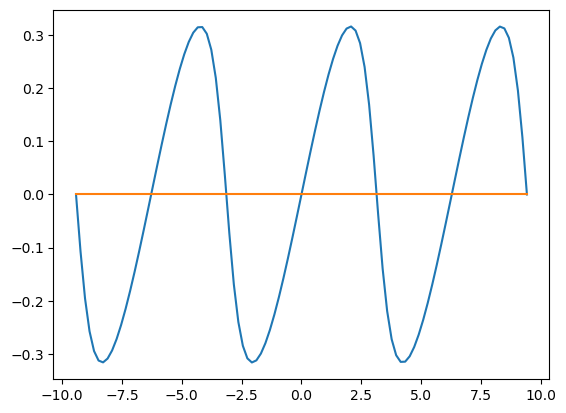

In [45]:
tharr = np.linspace(-3*pi, 3*pi, 101)

plt.plot(tharr, Va_QCD_prime(tharr)/(mpi**2 * fpi**2))
plt.plot(tharr, np.zeros_like(tharr))

del tharr

### 1.2.d Second field derivative of QCD axion potential

$V''(\theta) = z' \, m_\pi^2 f_\pi^2 \, F(T) \, \left( \frac{\cos\theta}{\chi(\theta)} + \frac{z' \sin^2(\theta)}{\chi^3(\theta)} \right)$

In [46]:
def Va_QCD_primeprime(theta, T=0, p=12, small=1.e-6):
    """
    Va_QCD_primeprime : the second field derivative of the axion QCD potential [GeV^4].

    Parameters:
    theta : axion field
    T : temperature [GeV] (default: 0)
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)

    Returns:
    Va_QCD_primeprime [GeV^4]
    """

    pref = mpi**2 * fpi**2
    ma2fa2 = zp*pref

    first_term = np.cos(theta)/chpt_fn(theta)
    second_term = zp * np.sin(theta)**2 / np.power(chpt_fn(theta), 3)

    vpp = ma2fa2*FTemp(T, p=p, small=small)*(first_term + second_term)

    return vpp

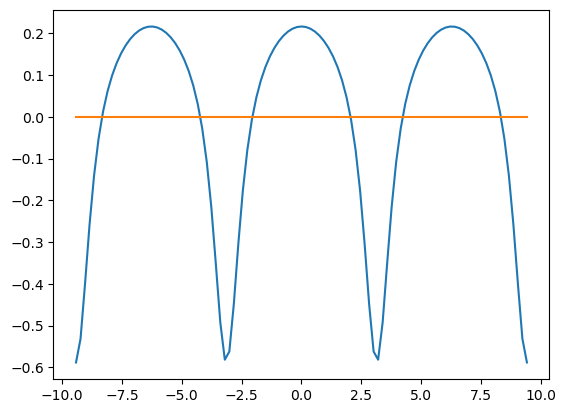

In [47]:
tharr = np.linspace(-3*pi, 3*pi, 101)

plt.plot(tharr, Va_QCD_primeprime(tharr)/(mpi**2 * fpi**2))
plt.plot(tharr, np.zeros_like(tharr))

del tharr

### 1.2.e QCD axion mass

Axion mass at zero temperature ($T=0$), *i.e.*, around $\theta = 0$:

$m_a(f_a) = \sqrt{z'} \, m_\pi f_\pi / f_a$

In [48]:
def ma_QCD(fa, T=0, p=12, small=1.e-6):
    """
    ma_QCD : mass of the axion [GeV], to leading order in chPT (i.e., the first term in Eq. (19) of arXiv:1511.02867).

    Parameters:
    fa : axion decay constant [GeV]
    T : temperature [GeV] (default: 0)
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)

    Returns:
    ma_QCD [GeV]
    """
    
    pref = mpi**2 * fpi**2
    ma2fa2 = zp * pref
    
    return np.sqrt(ma2fa2 * FTemp(T=T, p=p, small=small) / fa**2)

In [49]:
ma_QCD(1.e12) / eV

5.7744625260303095e-06

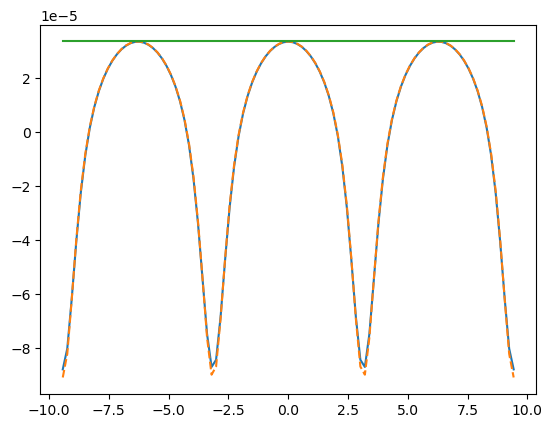

In [50]:
tharr = np.linspace(-3*pi, 3*pi, 101)

plt.plot(tharr, np.gradient(Va_QCD_prime(tharr), tharr))
plt.plot(tharr, Va_QCD_primeprime(tharr), ls='--')

plt.plot(tharr, np.ones_like(tharr)*ma_QCD(1)**2)

del tharr

## 1.3 $\mathbb{Z}_N$-axion Model

### 1.3.a $\mathbb{Z}_N$ axion potential

$V_N(\theta) \supset (m_a^2)_{\rm QCD} f_a^2 \, (-1)^N \frac{\epsilon_N}{N^2} \cos( N\theta )$,

with

$\epsilon_N \simeq \sqrt{\frac{1 - z^2}{\pi}} (1+z) N^{3/2} z^{N-1}$

In [449]:
def epsilon_N(N):
    """
    epsilon_N : suppression [dimless] of the QCD axion mass in the ZN-axion model.

    Parameters:
    N : number of SM copies [dimless, integer]

    Return:
    epsilon_N [dimless]
    """

    if N == np.inf:
        eps_N = 0
    else:
        eps_N = np.sqrt((1 - zud**2)/pi) * (1 + zud) * np.power(N, 3/2) * np.power(zud, N-1)

    return eps_N

In [450]:
def Va_N(theta, N, cancel_cc=True):
    """
    Va_N : axion potential [GeV^4] in the ZN model.

    Parameters:
    theta : axion field [radians]
    N : number of SM copies [dimless, integer]
    cancel_cc : whether we deduct the CC term (default: True)

    Returns:
    Va_N [GeV^4]
    """

    ma2fa2 = zp * mpi**2 * fpi**2

    eps_N = epsilon_N(N)
    
    prefN = ma2fa2*np.power(-1, N)*eps_N / np.power(N, 2)
    oscN = np.cos(N*theta)

    v = prefN*oscN
    
    if cancel_cc == True:
        v -= prefN
    
    return v

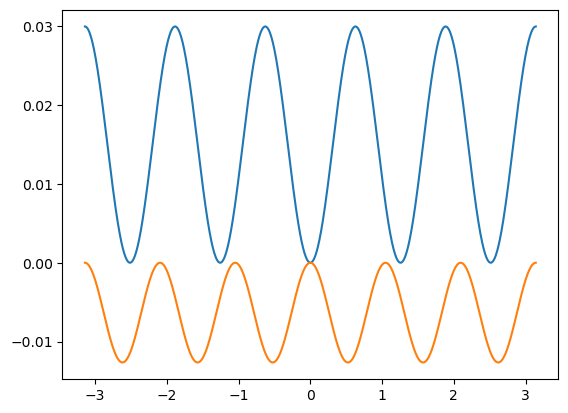

In [451]:
N1 = 5
N2 = 6

tharr = np.linspace(-pi, pi, 1001)

plt.plot(tharr, Va_N(tharr, N1)/(zp * mpi**2 * fpi**2))
plt.plot(tharr, Va_N(tharr, N2)/(zp * mpi**2 * fpi**2))

del N1, N2, tharr

### 1.3.b Field derivative of $\mathbb{Z}_N$ axion potential

$V_N'(\theta) = (m_a^2)_{\rm QCD} f_a^2 \, (-1)^{N+1} \frac{\epsilon_N}{N} \sin( N\theta )$

In [452]:
def Va_N_prime(theta, N):
    """
    Va_N_prime : field derivative of the axion potential [GeV^4] in the ZN model.

    Parameters:
    theta : axion field [radians]
    N : number of SM copies [dimless, integer]

    Returns:
    Va_N_prime [GeV^4]
    """

    ma2fa2 = zp * mpi**2 * fpi**2

    eps_N = epsilon_N(N)
    
    prefNp = ma2fa2*np.power(-1, N+1)*eps_N / N
    oscN = np.sin(N*theta)

    vp = prefNp*oscN
    
    return vp

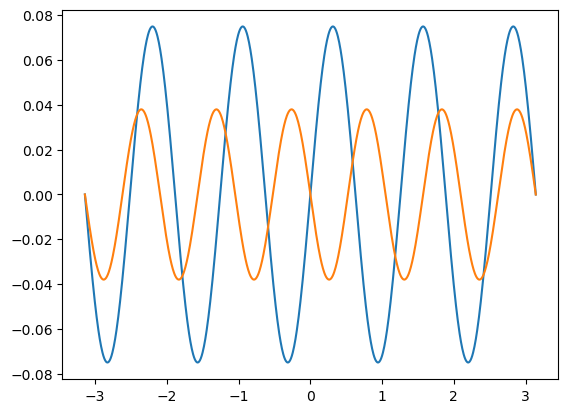

In [453]:
N1 = 5
N2 = 6

tharr = np.linspace(-pi, pi, 1001)

plt.plot(tharr, Va_N_prime(tharr, N1)/(zp * mpi**2 * fpi**2))
plt.plot(tharr, Va_N_prime(tharr, N2)/(zp * mpi**2 * fpi**2))

del N1, N2, tharr

### 1.3.c Second field derivative of $\mathbb{Z}_N$ axion potential

$V_N''(\theta) = (m_a^2)_{\rm QCD} f_a^2 \, (-1)^{N+1} \epsilon_N \cos( N\theta )$

In [454]:
def Va_N_primeprime(theta, N):
    """
    Va_N_primeprime : second field derivative of the axion potential [GeV^4] in the ZN model.

    Parameters:
    theta : axion field [radians]
    N : number of SM copies [dimless, integer]

    Returns:
    Va_N_primeprime [GeV^4]
    """

    ma2fa2 = zp * mpi**2 * fpi**2

    eps_N = epsilon_N(N)
    
    prefNp = ma2fa2*np.power(-1, N+1)*eps_N
    oscN = np.cos(N*theta)

    vpp = prefNp*oscN
    
    return vpp

### 1.3.d $\mathbb{Z}_N$ axion mass

$\left( m_a^2 \right)_N = (-1)^{N+1} \epsilon_N \left( m_a^2 \right)_{\rm QCD}$

In [455]:
def ma_N2(N, fa):
    """
    ma_N2 : squared axion mass [GeV^2] in the ZN model.

    Parameters:
    N : number of SM copies [dimless, integer]
    fa : axion decay constant [GeV]

    Returns:
    ma_N2 [GeV^2]
    """

    eps_N = epsilon_N(N)

    sup = np.power(-1, N+1)*eps_N

    return sup * ma_QCD(fa)**2

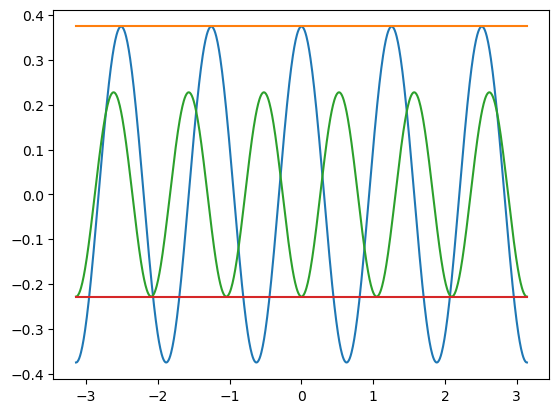

In [456]:
N1 = 5
N2 = 6

tharr = np.linspace(-pi, pi, 1001)

plt.plot(tharr, Va_N_primeprime(tharr, N1)/(zp * mpi**2 * fpi**2))
plt.plot(tharr, np.ones_like(tharr)*ma_N2(N1, 1)/(zp * mpi**2 * fpi**2))
plt.plot(tharr, Va_N_primeprime(tharr, N2)/(zp * mpi**2 * fpi**2))
plt.plot(tharr, np.ones_like(tharr)*ma_N2(N2, 1)/(zp * mpi**2 * fpi**2))

del N1, N2, tharr

### 1.3.e Reheaton contribution to axion potential

$V_\phi(T, \theta) = \frac{(m_a^2)_{\rm QCD} f_a^2}{z'} \left[ 1 - (1 + \epsilon_\phi) F(T)  \right] \, \chi(\theta) = m_\pi^2 f_\pi^2 \, \left[ 1 - (1 + \epsilon_\phi) F(T)  \right] \, \chi(\theta)$

In [457]:
def Va_phi(theta, T, eps_phi, p=12, small=1.e-6, cancel_cc=True):
    """
    Va_phi : axion potential [GeV^4] contribution from the reheaton in the ZN model.

    Parameters:
    theta : axion field [radians]
    T : temperature [GeV]
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)
    cancel_cc : whether we deduct the CC term (default: True)

    Returns:
    Va_phi [GeV^4]
    """
    
    pref = (mpi**2 * fpi**2)
    temp_pref = (1 - (1 + eps_phi)*FTemp(T, p=p, small=small))
    osc = chpt_fn(theta)

    v = pref*temp_pref*osc
    
    if cancel_cc == True:
        v -= -eps_phi * pref
    
    return v

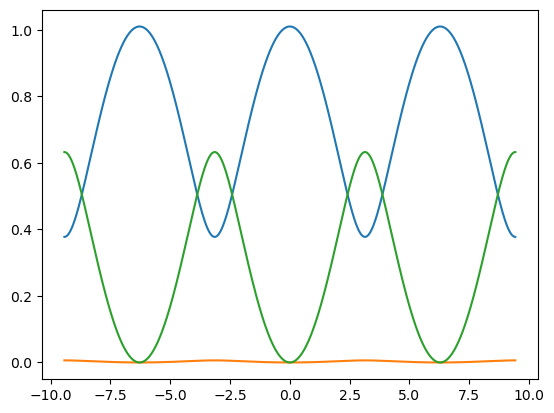

In [458]:
T1 = 10.*Tcrit
T2 = Tcrit/10.

ephi = 1.e-2

tharr = np.linspace(-3*pi, 3*pi, 1001)

plt.plot(tharr, Va_phi(tharr, T1, ephi)/(mpi**2 * fpi**2))
plt.plot(tharr, Va_phi(tharr, T2, ephi)/(mpi**2 * fpi**2))
plt.plot(tharr, Va_phi(tharr, T2, ephi)/(ephi * mpi**2 * fpi**2))

del T1, T2, ephi, tharr

### 1.3.f Field derivative of reheaton contribution to axion potential

$V_\phi'(\theta) = - z' m_\pi^2 f_\pi^2 \left[ 1 - (1+\epsilon_\phi) F(T) \right] \,\frac{\sin(\theta)}{\chi(\theta)}$

In [459]:
def Va_phi_prime(theta, T, eps_phi, p=12, small=1.e-6):
    """
    Va_phi_prime : field derivative of the axion potential [GeV^4] contribution from the reheaton in the ZN model.

    Parameters:
    theta : axion field [radians]
    T : temperature [GeV]
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)

    Returns:
    Va_phi_prime [GeV^4]
    """

    pref = (mpi**2 * fpi**2)
    ma2fa2 = zp*pref
    temp_pref = (1 - (1 + eps_phi)*FTemp(T, p=p, small=small))
    
    num = -ma2fa2*temp_pref*np.sin(theta)
    den = chpt_fn(theta)

    return num/den

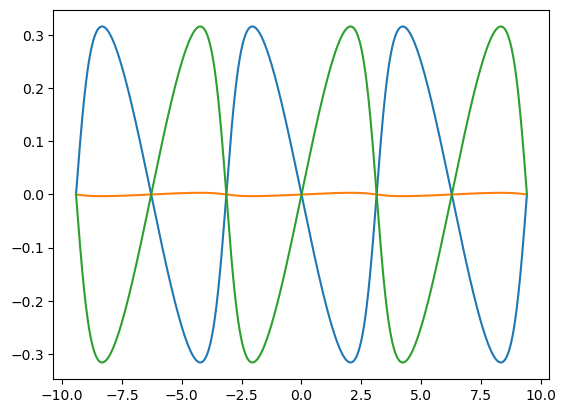

In [460]:
T1 = 10.*Tcrit
T2 = Tcrit/10.

ephi = 1.e-2

tharr = np.linspace(-3*pi, 3*pi, 1001)

plt.plot(tharr, Va_phi_prime(tharr, T1, ephi)/(mpi**2 * fpi**2))
plt.plot(tharr, Va_phi_prime(tharr, T2, ephi)/(mpi**2 * fpi**2))
plt.plot(tharr, Va_phi_prime(tharr, T2, ephi)/(ephi * mpi**2 * fpi**2))

del T1, T2, ephi, tharr

### 1.3.g Second field derivative of reheaton contribution to axion potential

$V_\phi''(\theta) = - z' \, m_\pi^2 f_\pi^2 \, \left[ 1 - (1+\epsilon_\phi) F(T) \right] \, \left( \frac{\cos\theta}{\chi(\theta)} + \frac{z' \sin^2(\theta)}{\chi^3(\theta)} \right)$

In [461]:
def Va_phi_primeprime(theta, T, eps_phi, p=12, small=1.e-6):
    """
    Va_phi_primeprime : second field derivative of the axion potential [GeV^4] contribution from the reheaton in the ZN model.

    Parameters:
    theta : axion field [radians]
    T : temperature [GeV]
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)

    Returns:
    Va_phi_primeprime [GeV^4]
    """

    pref = (mpi**2 * fpi**2)
    ma2fa2 = zp*pref
    temp_pref = (1 - (1 + eps_phi)*FTemp(T, p=p, small=small))

    first_term = np.cos(theta)/chpt_fn(theta)
    second_term = zp * np.sin(theta)**2 / np.power(chpt_fn(theta), 3)
    
    vpp = -ma2fa2*temp_pref*(first_term + second_term)

    return vpp

### 1.3.h Reheaton contribution to axion mass

$(m_a^2)_\phi = \epsilon_\phi (m_a^2)_{\rm QCD}$

In [462]:
def ma_phi2(eps_phi, fa):
    """
    ma_phi2 : axion mass squared [GeV^2] contribution from the reheaton in the ZN model.

    Parameters:
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    fa : axion decay constant [GeV]

    Returns:
    ma_phi2 [GeV^2]
    """

    return eps_phi*ma_QCD(fa)**2

At hight temperatures the minimum is $\theta = \pi$, and this is the axion mass:

$\left( m_a^2 \right)_{\pi} = \left( \frac{1+z}{1-z} \right) \, (m_a^2)_{\rm QCD}$

In [463]:
def ma_pi2(fa):

    pref = (1 + zud)/(1 - zud)

    return pref*ma_QCD(fa)**2

### 1.3.i Total axion potential

$V_{\rm tot}(T, \theta) = V_N(\theta) + V_\phi (T, \theta)$

In [464]:
def Vtot(theta, T, model, eps_phi, N, p=12, small=1.e-6, cancel_cc=True):
    """
    Vtot : total axion potential [GeV^4], summed over all contributions.

    Parameters:
    theta : axion field [radians]
    T : temperature [GeV]
    model : the axion model under consideration (can only be 'QCD' or 'ZN')
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    N : number of copies of the SM in the ZN model [dimless, integer]
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)
    cancel_cc : whether we deduct the CC term (default: True)

    Returns:
    Vtot [GeV^4]
    """

    if type(model) != str:
        raise TypeError("The argument 'model' must be a string, and equal to either 'QCD' or 'ZN'. The type you passed is '{}'".format(type(model)))

    if model == 'QCD':
        vtot = Va_QCD(theta, T=T, p=p, small=small, cancel_cc=cancel_cc)

    elif model == 'ZN':
        if N == np.inf:
            vn = 0.
        else:
            vn = Va_N(theta, N, cancel_cc=cancel_cc)

        vphi = Va_phi(theta, T, eps_phi, p=p, small=small, cancel_cc=cancel_cc)

        vtot = vn + vphi
    
    else:
        raise ValueError("The argument 'model' must be either 'QCD' or 'ZN'. You passed '{}'".format(model))
    
    return vtot

epsilon_N =  0.07496392083572753
epsilon_phi =  0.01


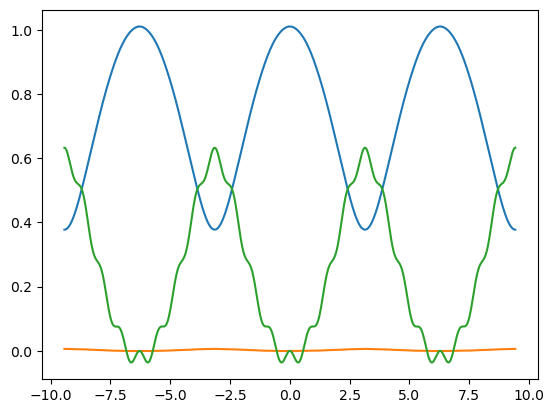

In [465]:
T1 = 10.*Tcrit
T2 = Tcrit/10.

ephi = 1.e-2
eN = 8

print("epsilon_N = ", epsilon_N(eN))
print("epsilon_phi = ", ephi)

tharr = np.linspace(-3*pi, 3*pi, 1001)

plt.plot(tharr, Vtot(tharr, T1, 'ZN', ephi, eN)/(mpi**2 * fpi**2))
plt.plot(tharr, Vtot(tharr, T2, 'ZN', ephi, eN)/(mpi**2 * fpi**2))
plt.plot(tharr, Vtot(tharr, T2, 'ZN', ephi, eN)/(ephi * mpi**2 * fpi**2))

del T1, T2, ephi, eN, tharr

### 1.3.j Field derivative of total axion potential

In [466]:
def Vtot_prime(theta, T, model, eps_phi, N, p=12, small=1.e-6):
    """
    Vtot_prime : field derivative of the total axion potential [GeV^4], summed over all contributions.

    Parameters:
    theta : axion field [radians]
    T : temperature [GeV]
    model : the axion model under consideration (can only be 'QCD' or 'ZN')
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    N : number of copies of the SM in the ZN model [dimless, integer]
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)

    Returns:
    Vtot_prime [GeV^4]
    """

    if type(model) != str:
        raise TypeError("The argument 'model' must be a string, and equal to either 'QCD' or 'ZN'. The type you passed is '{}'".format(type(model)))

    if model == 'QCD':
        vtotp = Va_QCD_prime(theta, T=T, p=p, small=small)
    
    elif model == 'ZN':
        if N == np.inf:
            vnp = 0.
        else:
            vnp = Va_N_prime(theta, N)

        vphip = Va_phi_prime(theta, T, eps_phi, p=p, small=small)

        vtotp = vnp + vphip

    else:
        raise ValueError("The argument 'model' must be either 'QCD' or 'ZN'. You passed '{}'".format(model))

    return vtotp

epsilon_N =  0.0032871285943440317
epsilon_phi =  0.01


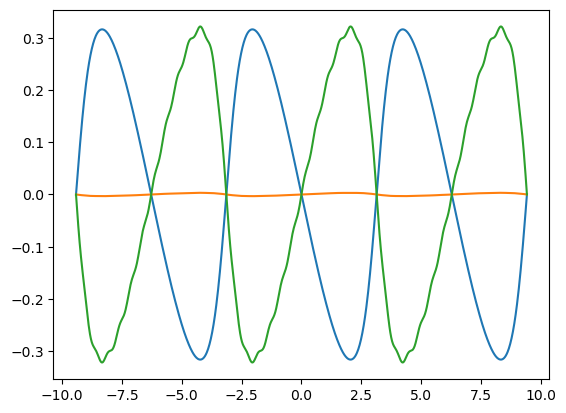

In [467]:
T1 = 10.*Tcrit
T2 = Tcrit/10.

ephi = 1.e-2
eN = 13

print("epsilon_N = ", epsilon_N(eN))
print("epsilon_phi = ", ephi)

tharr = np.linspace(-3*pi, 3*pi, 1001)

plt.plot(tharr, Vtot_prime(tharr, T1, 'ZN', ephi, eN)/(mpi**2 * fpi**2))
plt.plot(tharr, Vtot_prime(tharr, T2, 'ZN', ephi, eN)/(mpi**2 * fpi**2))
plt.plot(tharr, Vtot_prime(tharr, T2, 'ZN', ephi, eN)/(ephi * mpi**2 * fpi**2))

del T1, T2, ephi, eN, tharr

### 1.3.k Second field derivative of total axion potential

In [468]:
def Vtot_primeprime(theta, T, model, eps_phi, N, p=12, small=1.e-6):
    """
    Vtot_primeprime : second field derivative of the total axion potential [GeV^4], summed over all contributions.

    Parameters:
    theta : axion field [radians]
    T : temperature [GeV]
    model : the axion model under consideration (can only be 'QCD' or 'ZN')
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    N : number of copies of the SM in the ZN model [dimless, integer]
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)

    Returns:
    Vtot_primeprime [GeV^4]
    """

    if type(model) != str:
        raise TypeError("The argument 'model' must be a string, and equal to either 'QCD' or 'ZN'. The type you passed is '{}'".format(type(model)))

    if model == 'QCD':
        vtotpp = Va_QCD_primeprime(theta, T=T, p=p, small=small)
    
    elif model == 'ZN':
        if N == np.inf:
            vnpp = 0.
        else:
            vnpp = Va_N_primeprime(theta, N)

        vphipp = Va_phi_primeprime(theta, T, eps_phi, p=p, small=small)

        vtotpp = vnpp + vphipp

    else:
        raise ValueError("The argument 'model' must be either 'QCD' or 'ZN'. You passed '{}'".format(model))

    return vtotpp

### 1.3.l Total axion mass

Contributions from $\mathbb{Z}_N$ and reheaton:

In [469]:
def ma_tot2(eps_phi, N, fa):
    """
    ma_tot2 : the square of the total axion mass [GeV^2] in the ZN model (w/ reheaton).

    Parameters:
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    N : number of copies of the SM in the ZN model [dimless, integer]
    fa : axion decay constant [GeV]

    Returns:
    ma_tot2 [GeV^2]
    """

    return ma_phi2(eps_phi, fa) + ma_N2(N, fa)

The minimum value of $N$ for which the reheaton piece is the dominant contribution to the axion mass (although not that if $N$ is even then it will lead to an even smaller value of the total axion mass, since they will partially cancel out)

In [470]:
def Nmin(eps_phi):
    """
    Nmin : the smallest number of SM copies for which the N-copies contribution to the axion mass is smaller than a given reheaton contribution.

    Parameters : eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]

    Returns:
    Nmin [dimless, integer]
    """

    Nguess = 1 + (np.log(eps_phi) - np.log(np.sqrt((1 - zud**2)/pi) * (1 + zud)))/np.log(zud)
    Nguess += -(3/2)*np.log(Nguess)/np.log(zud)

    smallest_N = lambda eN: (epsilon_N(eN) - eps_phi)/eps_phi
    res = int(np.ceil(fsolve(smallest_N, Nguess)[0]))

    return res

In [471]:
eps_phi_test = 1.e-5
Nmin_test = Nmin(eps_phi_test)

print("eps_phi =", eps_phi_test, "\nN_min=", Nmin_test)
print("ma_phi2 fa2 =", ma_phi2(eps_phi_test, 1), "\nma_N2 fa2 =", ma_N2(Nmin_test, 1), "\nma_tot2 fa2 =", ma_tot2(eps_phi_test, Nmin_test, 1))

eps_phi = 1e-05 
N_min= 22
ma_phi2 fa2 = 3.3344417464528347e-10 
ma_N2 fa2 = -2.33771011982704e-10 
ma_tot2 fa2 = 9.967316266257946e-11


# 2. Axion Equations

## 2.1. Integration Time

### 2.1.a Time of onset of oscillations: $t_{\rm osc}$:

$3 H(t_{\rm osc}) = m_a(t_{\rm osc})$

In [472]:
def tosc(ma_fn):
    """
    tosc : time [GeV^-1] at which the axion oscillations begin.

    Parameters:
    ma_fn : axion mass [GeV] as a function of time [GeV^-1]

    Returns:
    tosc [GeV^-1]
    """

    # first, we search for a good estimate of the time of oscillation
    Tosc_guess = np.power( np.sqrt(10./(pi**2 * gs_fn(Tcrit))) * ma_fn(1.e10) * mpl, 2/(8+4)) * np.power(Tcrit, 8/(8+4)) # Eq. (49) of arXiv:2403.17697
    xosc_guess = 0.5/(tcrit * Hubble(rho_rad(gs_fn(Tosc_guess), Tosc_guess)))

    h_of_x = lambda x: tcrit*Hubt(x*tcrit) # dimless Hubble rate
    dimless_ma_of_x = lambda x: np.where(tcrit*ma_fn(x) < 1.e-16, 1.e-16, tcrit*ma_fn(x)) # dimless axion mass

    min_Lfn = lambda Lx: np.log10(dimless_ma_of_x(10.**Lx)) - np.log10(3*h_of_x(10.**Lx)) # function whose root we want

    # finding solution
    res = least_squares(min_Lfn, np.log10(xosc_guess), bounds=(np.log10(time_arr[1]/tcrit), np.inf))
    x_osc = (10.**res.x[0])

    return x_osc*tcrit

Test: QCD model

In [170]:
help(fsolve)

Help on function fsolve in module scipy.optimize._minpack_py:

fsolve(func, x0, args=(), fprime=None, full_output=0, col_deriv=0, xtol=1.49012e-08, maxfev=0, band=None, epsfcn=None, factor=100, diag=None)
    Find the roots of a function.
    
    Return the roots of the (non-linear) equations defined by
    ``func(x) = 0`` given a starting estimate.
    
    Parameters
    ----------
    func : callable ``f(x, *args)``
        A function that takes at least one (possibly vector) argument,
        and returns a value of the same length.
    x0 : ndarray
        The starting estimate for the roots of ``func(x) = 0``.
    args : tuple, optional
        Any extra arguments to `func`.
    fprime : callable ``f(x, *args)``, optional
        A function to compute the Jacobian of `func` with derivatives
        across the rows. By default, the Jacobian will be estimated.
    full_output : bool, optional
        If True, return optional outputs.
    col_deriv : bool, optional
        Specify w

In [228]:
ma_of_x = lambda x: ma_QCD(1.e17, T_fn(x*tcrit))
print("fa=1.e17 GeV, x_osc=",tosc(ma_of_x)/tcrit)

ma_of_x = lambda x: ma_QCD(1.e12, T_fn(x*tcrit))
print("fa=1.e12 GeV, x_osc=",tosc(ma_of_x)/tcrit)

fa=1.e17 GeV, x_osc= 0.9055642052006486
fa=1.e12 GeV, x_osc= 0.01697691598135192


Test: $\mathbb{Z}_N$ model

In [229]:
ma_of_x = lambda x: np.sqrt(ma_phi2(1.e-5, 1.e12))
print("fa=1.e12 GeV, eps_phi=1.e-5, x_osc=",tosc(ma_of_x)/tcrit)

ma_of_x = lambda x: np.sqrt(ma_phi2(1.e-15, 1.e12))
print("fa=1.e12 GeV, eps_phi=1.e-15, x_osc=",tosc(ma_of_x)/tcrit)

ma_of_x = lambda x: np.sqrt(ma_phi2(1.e-5, 1.e18))
print("fa=1.e18 GeV, eps_phi=1.e-5, x_osc=",tosc(ma_of_x)/tcrit)

ma_of_x = lambda x: np.sqrt(ma_phi2(1.e-15, 1.e18))
print("fa=1.e18 GeV, eps_phi=1.e-15, x_osc=",tosc(ma_of_x)/tcrit)

fa=1.e12 GeV, eps_phi=1.e-5, x_osc= 0.0023013637256831926
fa=1.e12 GeV, eps_phi=1.e-15, x_osc= 232.00587774597565
fa=1.e18 GeV, eps_phi=1.e-5, x_osc= 2295.98657353591
fa=1.e18 GeV, eps_phi=1.e-15, x_osc= 229805223.48906592


### 2.1.b Interval of Integration

Defining convenient integration boundaries:

In [234]:
def find_x_interval(model, fa, eps_phi, ini_factor, end_factor):
    """
    find_x_interval : find a reasonable interval in dimless time x=t/tcrit in which to perform the integration of the axion equations of motion, centered around the oscillation time x_osc = t_osc/tcrit.

    Parameters:
    model : the axion model under consideration (can only be 'QCD' or 'ZN')
    fa : axion decay constant [GeV]
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    ini_factor : ratio t_ini/t_osc
    end_factor : ratio t_end/t_osc

    Returns:
    (x_ini, x_end) [dimless]
    """

    if model == 'QCD':
        ma_of_xini = lambda x: ma_QCD(fa, T_fn(x*tcrit))
        ma_of_xend = ma_of_xini

    elif model == 'ZN':
        ma_of_xini = lambda x: np.sqrt(ma_pi2(fa))
        ma_of_xend = lambda x: np.sqrt(ma_phi2(eps_phi, fa))

    else:
        raise ValueError("The argument 'model' must be either 'QCD' or 'ZN'. You passed '{}'".format(model))
    
    x_ini = tosc(ma_of_xini)/tcrit
    x_end = tosc(ma_of_xend)/tcrit

    x_ini *= ini_factor
    x_end *= end_factor


    return (x_ini, x_end)

In [235]:
find_x_interval('QCD', 1.e17, 1, 0.01, 100)

(0.009055642052006487, 90.55642052006486)

In [236]:
find_x_interval('QCD', 1.e15, 1, 0.01, 100)

(0.0013416172053958998, 13.416172053958997)

In [237]:
find_x_interval('ZN', 1.e17, 1.e-5, 0.01, 100)

(0.004666366914855272, 23200.587774597567)

In [238]:
find_x_interval('ZN', 1.e15, 1.e-5, 0.01, 100)

(4.418589257451644e-05, 244.31889148261695)

In [239]:
find_x_interval('blah', 1.e17, 1.e-5, 51, 0.01, 100)

TypeError: find_x_interval() takes 5 positional arguments but 6 were given

### 2.1.c Natural Timescale

In [240]:
def natural_timescale(model, fa, eps_phi, N, time_units):
    """
    natural_timescale : The natural timescale [GeV^-1] of a given axion model.

    Parameters:
    model : the axion model under consideration (can only be 'QCD' or 'ZN')
    fa - axion decay constant [GeV]
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    N : number of copies of the SM in the ZN model [dimless, integer]
    time_units : whether time is in units of tcrit or min[tcrit, 1/maxion] (at zero temperature) (default: 'tcrit')

    Returns:
    natural_timescale [GeV^-1]
    """
    if type(time_units) != str:
        raise TypeError("The argument 'time_units' must be a string, and equal to either 'tcrit' or '1/maxion'. The type you passed is '{}'".format(type(time_units)))

    if time_units == 'tcrit':
        timescale = tcrit

    elif time_units == '1/maxion':
        if model == 'QCD':
            timescale = min([tcrit, 1/ma_QCD(fa)])
        elif model == 'ZN':
            timescale = min([tcrit, 1/np.sqrt(max([ma_tot2(eps_phi, N, fa), ma_phi2(eps_phi, fa), ma_pi2(fa)]))])
        else:
            raise ValueError("The argument 'model' must be either 'QCD' or 'ZN'. You passed '{}'".format(model))
    else:
        raise ValueError("The argument 'time_units' must be either 'tcrit' or '1/maxion'. You passed '{}'".format(time_units))
        
    return timescale

## 2.2 Axion EOM

**TO DO:**

- Write code for switcheroo method: solving axion_eom in the fast-oscillating regime (patch solutions past xosc by providing an ansatz with the multi-scale method; add integral and derivative of mass w.r.t. time (improve dFdT too))

- Write jacobian, and jac_sparse for all cases


- Cross-check: since I have solved for $H(t)$ in the radiation-dominated era, solutions will be inconsistent if:
  - axion has a significant energy density (including CC) when oscillating around $\theta = \pi$, and/or
  - oscillations must begin before matter domination too.
    

- Define routine function from beginning to end, taking parameters as inputs, defining xini and xend (integration interval), solving eom, computing omega_dm, and performing MCMC analysis

### 2.2.a Full EOM

#### 2.2.a.i EOM

$\ddot{\theta} + 3 H(t) \dot{\theta} + V'(\theta, t) = 0$

In [241]:
def axion_eom(x, Y, model, fa, eps_phi, N, p=12, small=1.e-6, time_units='tcrit'):
    """
    axion_eom : Equations of motion of the axion field. Converts the originally nonlinear second-order ODE into a system of two first-order ODEs.

    Parameters:
    x : dimensionless time - independent variable [dimless]
    Y : axion angle and its time derivative - dependent variables [y, y'] = [theta, theta'] ][radians, radians]
    model : the axion model under consideration (can only be 'QCD' or 'ZN')
    fa - axion decay constant [GeV]
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    N : number of copies of the SM in the ZN model [dimless, integer]
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)
    time_units : whether time is in units of tcrit or min[tcrit, 1/maxion] (at zero temperature) (default: 'tcrit')

    Returns:
    [y', y''] = [theta', theta''] [dimless, dimless]
    """

    timescale = natural_timescale(model, fa, eps_phi, N, time_units) # timescale to use

    y, dy = Y # breaking down the tuplet

    temp = T_fn(x*timescale) # temperature [GeV]
    h = timescale*Hubt(x*timescale) # dimless Hubble rate

    dimfac = (timescale/fa)**2 # prefactor to turn potential into dimless quantity
    vp = dimfac*Vtot_prime(y, temp, model, eps_phi, N, p=p, small=small) # field derivative of the potential [dimless]

    ddy = -3*h*dy - vp

    return [dy, ddy]

#### 2.2.a.ii Axion Jacobian

Now we define the Jacobian matrix for the system of differential equations. This should help the `solve_ivp` routine.

Defining $y_1 \equiv \theta$ and $y_2 \equiv \dot\theta$, we can transform the single second-order ODE into two first-order ODE as follows:

$\dot{y}_1 = f_1 \equiv y_2$

(since $\dot{\theta} = \dot{\theta}$, duh!), and

$\dot{y}_2 = f_2 \equiv - 3 H(t) y_2 - V'(y_1, t)$

The jacobian $\mathcal{J}(t, \vec{y})$ is a matrix defined as

$\mathcal{J}_{i,j} \equiv \frac{\partial f_i}{\partial y_j}$.

Clearly, then, in our case we have:

$\mathcal{J}_{1,1} = 0$

$\mathcal{J}_{1,2} = 1$

$\mathcal{J}_{2,1} = -V''(y_1, t)$

$\mathcal{J}_{2,2} = -3 H(t)$

Thus, we know these entries analytically, and also, there is some degree of sparsity to the matrix (which actually changes over time, since $-V''(y_1, t)$ vanishes at large temperatures... but let's ignore that for now).

In [242]:
def axion_jac(x, Y, model, fa, eps_phi, N, p=12, small=1.e-6, time_units='tcrit'):
    """
    axion_jac : The Jacobian matrix for the axion EOM when written as as system of two first-order ODEs.

    Parameters:
    x : dimensionless time - independent variable [dimless]
    Y : axion angle and its time derivative - dependent variables [y, y'] = [theta, theta'] ][radians, radians]
    model : the axion model under consideration (can only be 'QCD' or 'ZN')
    fa - axion decay constant [GeV]
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    N : number of copies of the SM in the ZN model [dimless, integer]
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)
    time_units : whether time is in units of tcrit or min[tcrit, 1/maxion] (at zero temperature) (default: 'tcrit')

    Returns:
    [[J11, J12], [J21, J22]]
    """

    timescale = natural_timescale(model, fa, eps_phi, N, time_units) # timescale to use

    y, dy = Y # breaking down the tuplet

    temp = T_fn(x*timescale) # temperature [GeV]
    h = timescale*Hubt(x*timescale) # dimless Hubble rate

    dimfac = (timescale/fa)**2 # prefactor to turn potential into dimless quantity
    vpp = dimfac*Vtot_primeprime(y, temp, model, eps_phi, N, p=p, small=small) # second field derivative of the potential [dimless]

    # first row of Jacobian
    jac11 = 0
    jac12 = 1

    # second row of Jacobian
    jac21 = -vpp
    jac22 = -3*h

    jac = [[jac11, jac12], [jac21, jac22]] # the Jacobian matrix

    return jac

### 2.2.b Multi-scale expansion
(fast+slow, or oscillations+modulation)

#### 2.2.b.i EOM

#### 2.2.b.ii Axion Jacobian

## 2.3 Solving the axion EOM

### 2.3.a Brute force

In [243]:
def solve_axion_eom(model, fa, eps_phi, N, y0, dy0, x_interval, p=12, small=1.e-6, time_units='tcrit', method='Radau', **kwargs):
    """
    solve_axion_eom : solves the axion equations of motion with given initial conditions.

    Parameters:
    model : the axion model under consideration (can only be 'QCD' or 'ZN')
    fa - axion decay constant [GeV]
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    N : number of copies of the SM in the ZN model [dimless, integer]
    y0 : initial condition for axion angle, theta [radians]
    dy0 : initial condition for dimless time derivative of axion angle, theta' [radians]
    x_interval : tuple - integration interval (x_ini, x_end) of dimensionless time [dimless]
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)
    time_units : whether time is in units of tcrit or min[tcrit, 1/maxion] (at zero temperature) (default: 'tcrit')
    method : integration method (default: 'Radau')

    Returns:
    solution object
    """

    timescale = natural_timescale(model, fa, eps_phi, N, time_units) # timescale to use
    rescaled_interval = (x_interval[0] * tcrit / timescale, x_interval[1] * tcrit / timescale) # new interval

    rescaled_dy0 = dy0*(tcrit/timescale) # rescaling the initial value of the time derivative

    axion_sparsity = csr_matrix([[0, 1], [1, 1]])

    sol = solve_ivp(axion_eom, rescaled_interval, [y0, rescaled_dy0], args=(model, fa, eps_phi, N, p, small, time_units), method=method, jac=axion_jac, jac_sparsity=axion_sparsity, **kwargs)

    if time_units == '1/maxion':
        # need to rescale back to x = t/tcrit once again
        sol.t *= timescale/tcrit # the time array
        sol.y[1] *= tcrit/timescale # the time derivative

    return sol

### 2.3.b Switcheroo

## 2.4 Axion energy density and abundance

$\rho_a(t)$

In [244]:
def axion_density(x, Y, model, fa, eps_phi, N, p=12, small=1.e-6):
    """
    axion_density : axion energy density [GeV^4].

    Parameters:
    x : dimensionless time t/tcrit - independent variable [dimless]
    Y : axion angle and its time derivative - dependent variables [y, y'] = [theta, theta'] ][radians, radians]
    model : the axion model under consideration (can only be 'QCD' or 'ZN')
    fa - axion decay constant [GeV]
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    N : number of copies of the SM in the ZN model [dimless, integer]
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)
    
    Returns:
    axion_density [GeV^4]
    """

    theta, dtheta = Y
    temp = Tcrit*T_hat_fn(x)

    ke = 0.5 * dtheta**2 * (fa/tcrit)**2
    pe = Vtot(theta, temp, model, eps_phi, N, p=p, small=small, cancel_cc=True)

    en = ke + pe

    return en

$\Omega_a h^2$

In [245]:
def axion_abundance(rho_Arr, x_Arr, xosc):
    """
    axion_abundance : calculate the axion abundance [dimless] today, Omega_a*h^2
    
    Parameters:
    rho_Arr : array of axion energy density values [GeV^4]
    x_Arr : array of times, in units of tcrit [dimless]
    xosc : time at which the last axion oscillation began, in units of tcrit [dimless]
    
    Returns:
    axion_abundance : omega_a = Omega_a * h**2 [dimless]
    """

    a_Arr = scale_factor(x_Arr*tcrit) # computing scale factor array

    rhoa3_Arr = rho_Arr * np.power(a_Arr, 3) # computing rho_axion * a^3

    norm_rhoa3_Arr = rhoa3_Arr / rhoa3_Arr[-1] # normalized to the last entry (simply to make units more natural).

    xend = x_Arr[-1] # the last time computed
    last_third = np.log10(xend/xosc)/3. # in log-space, the last 1/3 of the integration interval; by this time we expect that the axion oscillations have died out
    xini = xend / np.power(10., last_third) # the lowest time we shall consider for the computation of the axion energy density.
    # xini = max([xini, 10.]) # must also be sufficiently beyond the QCD PT (which occurs at x=1)

    xini_idx = np.argmin(np.abs(x_Arr - xini)) # the location of xini in x_Arr

    print("xend=", xend)
    print("xini=", xini, "xini_idx=", xini_idx)
    print("last third=", last_third)

    # now, we construct the integrand of norm_rhoa3_Arr. Because of the oscillations, it is not exactly equal to 1 at late times throughout, so we will average its value over the last third
    integrand_Arr = norm_rhoa3_Arr[xini_idx:] * a_Arr[xini_idx:] # array of integrand (rho*a^3 * a) values
    lna_Arr = np.log(a_Arr[xini_idx:]) # array of ln(a) values

    print("norm_rhoa3=", norm_rhoa3_Arr[xini_idx:])
    print("a_Arr=", a_Arr[xini_idx:])
    print("lna_Arr=", lna_Arr[xini_idx:])

    exact_norm = simpson(integrand_Arr, lna_Arr) / simpson(a_Arr[xini_idx:], lna_Arr)
    print("exact norm=", exact_norm)

    Omega_a = exact_norm*rhoa3_Arr[-1]/rho_crit

    omega_a = Omega_a * h * h

    return omega_a

## 2.5 Testing

Initial conditions:

In [246]:
theta_ini, dtheta_ini = 1, 0

### 2.5.a QCD axion

Defining the parameters:

In [564]:
fa_test = (1.e12)*GeV # axion decay constant
epsphi_test = 1.e-6 # suppression in axion mass squared
N_test = np.inf # number of SM copies

Integration interval

In [565]:
x_osc = find_x_interval('QCD', fa_test, epsphi_test, 1, 1)[0] # dimless oscillation time for QCD
x_span = find_x_interval('QCD', fa_test, epsphi_test, 0.01, 1000) # dimless integration interval for QCD

print("QCD: x_osc={:g}".format(x_osc))
print("QCD: x_span=({:g}, {:g})".format(x_span[0], x_span[1]))

QCD: x_osc=0.0169769
QCD: x_span=(0.000169769, 16.9769)


Solving the EOM

In [566]:
# solve_axion_eom(model, fa, eps_phi, N, y0, dy0, x_span, p=12, small=1.e-6, method='BDF', **kwargs)

In [374]:
sol1 = solve_axion_eom('QCD', fa_test, epsphi_test, N_test, theta_ini, dtheta_ini, x_span, p=8, small=1.e-6, time_units='tcrit', method='BDF', atol=1.e-6, rtol=1.e-5) # solving QCD axion EOM w/ BDF method and x = t/tcrit

sol2 = solve_axion_eom('QCD', fa_test, epsphi_test, N_test, theta_ini, dtheta_ini, x_span, p=8, small=1.e-6, time_units='tcrit', method='Radau', atol=1.e-6, rtol=1.e-5) # solving QCD axion EOM w/ Radau method and x = t/tcrit

sol3 = solve_axion_eom('QCD', fa_test, epsphi_test, N_test, theta_ini, dtheta_ini, x_span, p=8, small=1.e-6, time_units='1/maxion', method='Radau', atol=1.e-6, rtol=1.e-5) # solving QCD axion EOM w/ Radau method and x = t/tcrit

UsageError: Line magic function `%%timeit` not found.


In [375]:
%%timeit
sol3 = solve_axion_eom('QCD', 1.e13, epsphi_test, N_test, theta_ini, dtheta_ini, x_span, p=8, small=1.e-6, time_units='1/maxion', method='Radau', atol=1.e-6, rtol=1.e-5) # solving QCD axion EOM w/ Radau method and x = t/tcrit

24.5 s ± 330 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
sol3 = solve_axion_eom('QCD', fa_test, epsphi_test, N_test, theta_ini, dtheta_ini, x_span, p=8, small=1.e-6, time_units='1/maxion', method='Radau', atol=1.e-6, rtol=1.e-5) # solving QCD axion EOM w/ Radau method and x = t/tcrit

In [ ]:
print(len(sol3.t))

In [ ]:
print(len(sol1.t))
print(len(sol2.t))
print(len(sol3.t))

Important results:

In [ ]:
# resulting temperature arrays
temp_arr1 = Tcrit*T_hat_fn(sol1.t)
temp_arr2 = Tcrit*T_hat_fn(sol2.t)
temp_arr3 = Tcrit*T_hat_fn(sol3.t)
# temp_arr4 = Tcrit*T_hat_fn(sol4.t)

# energy density
rho_arr1 = (tcrit/fa_test)**2 * axion_density(sol1.t, (sol1.y[0], sol1.y[1]), 'QCD', fa_test, 1, 1)
rho_arr2 = (tcrit/fa_test)**2 * axion_density(sol2.t, (sol2.y[0], sol2.y[1]), 'QCD', fa_test, 1, 1)
rho_arr3 = (tcrit/fa_test)**2 * axion_density(sol3.t, (sol3.y[0], sol3.y[1]), 'QCD', fa_test, 1, 1)
# rho_arr4 = (tcrit/fa_test)**2 * axion_density(sol4.t, (sol4.y[0], sol4.y[1]), 'QCD', fa_test, 1, 1)

# scale factor
a_arr1 = scale_factor(sol1.t*tcrit)
a_arr2 = scale_factor(sol2.t*tcrit)
a_arr3 = scale_factor(sol3.t*tcrit)
# a_arr4 = scale_factor(sol4.t*tcrit)

In [ ]:
# Plot the result
plt.plot(sol1.t, sol1.y[0], label=r"[BDF, tcrit]")
plt.plot(sol2.t, sol2.y[0], label=r"[Radau, tcrit]")
plt.plot(sol3.t, sol3.y[0], label=r"[Radau, 1/maxion]")
plt.xlabel(r"$x = t/t_{\rm crit}$")
plt.ylabel(r"$\theta$")
plt.axvline(x=x_osc, color='k', ls='--')
plt.title("Evolution of the QCD axion angle")
plt.legend()
plt.grid()
plt.show()

# in log-space
plt.plot(sol1.t, sol1.y[0], label=r"[BDF, tcrit]")
plt.plot(sol2.t, sol2.y[0], label=r"[Radau, tcrit]")
plt.plot(sol3.t, sol3.y[0], label=r"[Radau, 1/maxion]")
# plt.plot(sol3.t, sol3.y[0], label=r"[Radau, 1/maxion]", marker="o")
plt.xlabel(r"$x = t/t_{\rm crit}$"), plt.xscale('log')
plt.ylabel(r"$\theta$")
plt.xlim(1, 1.01), plt.ylim(-0.03,0.03)
plt.axvline(x=x_osc, color='k', ls='--')
plt.title("Evolution of the QCD axion angle (log-space)")
plt.legend()
plt.grid()
plt.show()

# derivatives
plt.plot(sol2.t, sol2.y[0], label=r"$\theta(x)$ [BDF, tcrit]")
plt.plot(sol2.t, sol2.y[1], label=r"$\theta(x)'$ [BDF, tcrit]")
# plt.plot(sol1.t, np.gradient(sol1.y[0], sol1.t), label=r"$\theta(x)'$ [BDF, tcrit; gradient]")
plt.xlim(x_span[0], 30*x_osc)
plt.xlabel(r"$x = t/t_{\rm crit}$")
plt.ylabel(r"$\theta$")
plt.axvline(x=x_osc, color='k', ls='--')
plt.title("Time derivatives")
plt.legend()
plt.grid()
plt.show()

Finding out scaling with scale factor; comparing both methods:

In [ ]:
plt.plot(sol1.t, rho_arr1, label=r"[BDF, tcrit]")
plt.plot(sol2.t, rho_arr2, label=r"[Radau, 'tcrit']")
plt.plot(sol3.t, rho_arr3, label=r"[Radau, '1/maxion']")
plt.xlabel(r"$x = t/t_{\rm crit}$"), plt.xscale('log')
plt.xlim(1.2, 1.21), plt.ylim(1.e7, 2.e7)
plt.ylabel(r"$\rho_a$"), plt.yscale('log')
plt.axvline(x=x_osc, color='k', ls='--')
plt.title("Energy density of the QCD axion")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# as a function of t
plt.plot(sol1.t, (rho_arr1/ rho_arr1[-1])*(sol1.t/sol1.t[-1])**(3/2), label=r"[BDF, tcrit]")
plt.plot(sol2.t, (rho_arr2/ rho_arr2[-1])*(sol2.t/sol2.t[-1])**(3/2), label=r"[Radau, tcrit]")
plt.plot(sol3.t, (rho_arr3/ rho_arr3[-1])*(sol3.t/sol3.t[-1])**(3/2), label=r"[Radau, 1/maxion]")
# plt.plot(sol3.t, (rho_arr3/ rho_arr3[-1])*(a_arr3/a_arr3[-1])**3, label=r"[Radau, 1/maxion]", marker=".")
plt.plot(sol2.t, np.ones_like(sol2.t), label=r"const.", ls=':', color='k')
plt.xlabel(r"$x = t/t_{\rm crit}$"), plt.xscale('log')
plt.xlim(x_osc, x_span[-1])
plt.ylabel(r"$\rho_a t^{3/2}$"), plt.yscale('log')
# plt.ylim(0.3, 3)
plt.axvline(x=x_osc, color='k', ls='--')
plt.title("Scaling of the energy density of the QCD axion")
plt.legend()
plt.grid()
plt.show()

# as a function of t
plt.plot(sol1.t, (rho_arr1/ rho_arr1[-1])*(a_arr1/a_arr1[-1])**3, label=r"[BDF, tcrit]")
plt.plot(sol2.t, (rho_arr2/ rho_arr2[-1])*(a_arr2/a_arr2[-1])**3, label=r"[Radau, tcrit]")
plt.plot(sol3.t, (rho_arr3/ rho_arr3[-1])*(a_arr3/a_arr3[-1])**3, label=r"[Radau, 1/maxion]")
plt.plot(sol2.t, np.ones_like(sol2.t), label=r"const.", ls=':', color='k')
plt.xlabel(r"$x = t/t_{\rm crit}$"), plt.xscale('log')
plt.xlim(x_osc, x_span[-1])
plt.ylabel(r"$\rho_a a^3$"), plt.yscale('log')
plt.ylim(0.03, 30)
plt.axvline(x=x_osc, color='k', ls='--')
plt.title("Scaling of the energy density of the QCD axion")
plt.legend()
plt.grid()
plt.show()

# as a function of a
plt.plot(a_arr1, (rho_arr1/ rho_arr1[-1])*(a_arr1/a_arr1[-1])**3, label=r"[BDF, tcrit]")
plt.plot(a_arr2, (rho_arr2/ rho_arr2[-1])*(a_arr2/a_arr2[-1])**3, label=r"[Radau, tcrit]")
plt.plot(a_arr3, (rho_arr3/ rho_arr3[-1])*(a_arr3/a_arr3[-1])**3, label=r"[Radau, 1/maxion]")
plt.plot(a_arr2, np.ones_like(sol2.t), label=r"const.", ls=':', color='k')
plt.xlabel(r"$a$"), plt.xscale('log')

alo = min([a_arr1[np.argmin(np.abs(x_osc - sol1.t))], a_arr2[np.argmin(np.abs(x_osc - sol2.t))]])
ahi = max([a_arr1[-1], a_arr2[-1]])

print(alo, ahi)

plt.xlim(alo, ahi)
plt.ylabel(r"$\rho_a a^3$"), plt.yscale('log')
# plt.ylim(0.3, 3)
# plt.axvline(x=x_osc, color='k', ls='--')
plt.title("Scaling of the energy density of the QCD axion")
plt.legend()
plt.grid()
plt.show()


del alo, ahi

In [ ]:
axion_abundance(rho_arr3, sol3.t, x_osc)

In [ ]:
plt.loglog(sol3.t, gs_fn(T_fn(sol3.t*tcrit)))

Clearing definitions

In [ ]:
# del fa_test, epsphi_test, N_test, x_osc, x_span, theta_ini, dtheta_ini, sol1, sol2, temp_arr1, temp_arr2, rho_arr1, rho_arr2, a_arr1, a_arr2

### 2.5.b $\mathbb{Z}_N$-axion

Defining the parameters:

In [537]:
fa_test = (3.e15)*GeV # axion decay constant
epsphi_test = 1.e-10 # suppression in axion mass squared
N_test = np.inf # number of SM copies

Integration interval

In [538]:
x_osc = find_x_interval('ZN', fa_test, epsphi_test, 1, 1)[0] # dimless oscillation time for ZN
x_span = find_x_interval('ZN', fa_test, epsphi_test, 0.01, 10000) # dimless integration interval for ZN

print("ZN: x_osc={:g}".format(x_osc))
print("ZN: x_span=({:g}, {:g})".format(x_span[0], x_span[1]))

ZN: x_osc=0.0133026
ZN: x_span=(0.000133026, 2.17821e+07)


Solving the EOM

In [539]:
sol1 = solve_axion_eom('ZN', fa_test, epsphi_test, N_test, theta_ini, dtheta_ini, x_span, p=8, small=1.e-6, time_units='1/maxion', method='BDF', atol=1.e-6, rtol=1.e-5) # solving ZN axion EOM w/ BDF method

In [540]:
sol2 = solve_axion_eom('ZN', fa_test, epsphi_test, N_test, theta_ini, dtheta_ini, x_span, p=8, small=1.e-6, time_units='1/maxion', method='Radau', atol=1.e-6, rtol=1.e-5) # solving ZN axion EOM w/ Radau method

In [541]:
print(len(sol1.t))
print(len(sol2.t))
print((sol2.y).shape)

30539
4606
(2, 4606)


Important results:

In [546]:
# resulting temperature arrays
temp_arr1 = Tcrit*T_hat_fn(sol1.t)
temp_arr2 = Tcrit*T_hat_fn(sol2.t)

# energy density
rho_arr1 = (tcrit/fa_test)**2 * axion_density(sol1.t, (sol1.y[0], sol1.y[1]), 'ZN', fa_test, 1, 1)
rho_arr2 = (tcrit/fa_test)**2 * axion_density(sol2.t, (sol2.y[0], sol2.y[1]), 'ZN', fa_test, 1, 1)

# scale factor
a_arr1 = scale_factor(sol1.t*tcrit)
a_arr2 = scale_factor(sol2.t*tcrit)

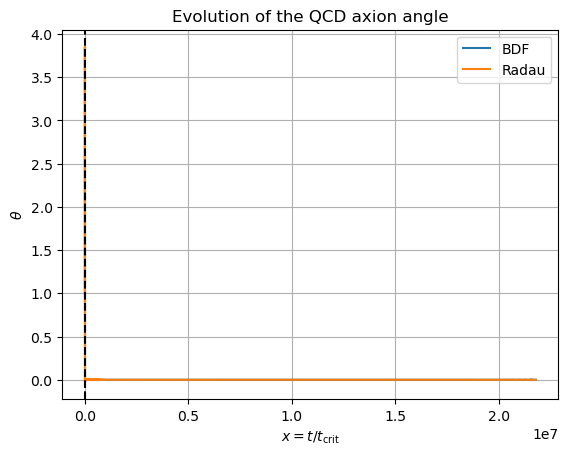

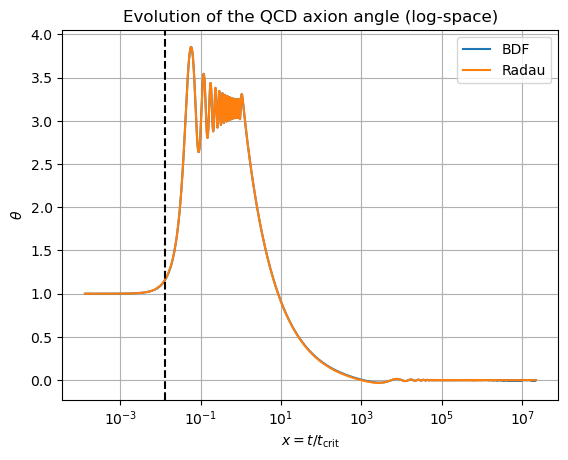

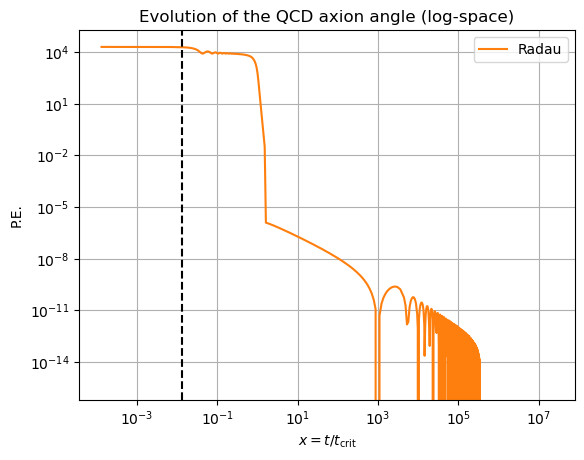

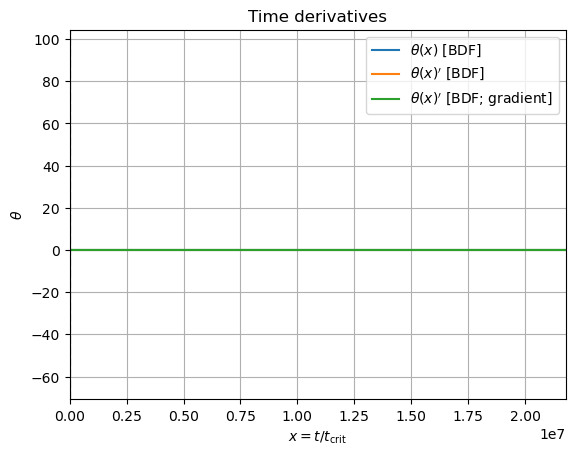

In [547]:
# Plot the result
plt.plot(sol1.t, sol1.y[0], label=r"BDF")
plt.plot(sol2.t, sol2.y[0], label=r"Radau")
plt.xlabel(r"$x = t/t_{\rm crit}$")
plt.ylabel(r"$\theta$")
plt.axvline(x=x_osc, color='k', ls='--')
plt.title("Evolution of the QCD axion angle")
plt.legend()
plt.grid()
plt.show()

# in log-space
plt.plot(sol1.t, sol1.y[0], label=r"BDF")
plt.plot(sol2.t, sol2.y[0], label=r"Radau")
plt.xlabel(r"$x = t/t_{\rm crit}$"), plt.xscale('log')
plt.ylabel(r"$\theta$")
plt.axvline(x=x_osc, color='k', ls='--')
plt.title("Evolution of the QCD axion angle (log-space)")
plt.legend()
plt.grid()
plt.show()

# potential
pe_arr = (tcrit/fa_test)**2 * Vtot(sol2.y[0], temp_arr2, 'ZN', epsphi_test, N_test, p=8, small=1.e-6) # field derivative of the potential [dimless]
# plt.plot(sol1.t, sol1.y[0], label=r"BDF")
plt.plot(sol2.t, pe_arr, label=r"Radau", color='C1')
plt.xlabel(r"$x = t/t_{\rm crit}$"), plt.xscale('log')
plt.ylabel(r"P.E."), plt.yscale('log')
plt.axvline(x=x_osc, color='k', ls='--')
plt.title("Evolution of the QCD axion angle (log-space)")
plt.legend()
plt.grid()
plt.show()

del pe_arr

# derivatives
plt.plot(sol1.t, sol1.y[0], label=r"$\theta(x)$ [BDF]")
plt.plot(sol1.t, sol1.y[1], label=r"$\theta(x)'$ [BDF]")
plt.plot(sol1.t, np.gradient(sol1.y[0], sol1.t), label=r"$\theta(x)'$ [BDF; gradient]")
plt.xlim(x_span[0], x_span[-1])
plt.xlabel(r"$x = t/t_{\rm crit}$")
plt.ylabel(r"$\theta$")
plt.axvline(x=x_osc, color='k', ls='--')
plt.title("Time derivatives")
plt.legend()
plt.grid()
plt.show()

Finding out scaling with scale factor; comparing both methods:

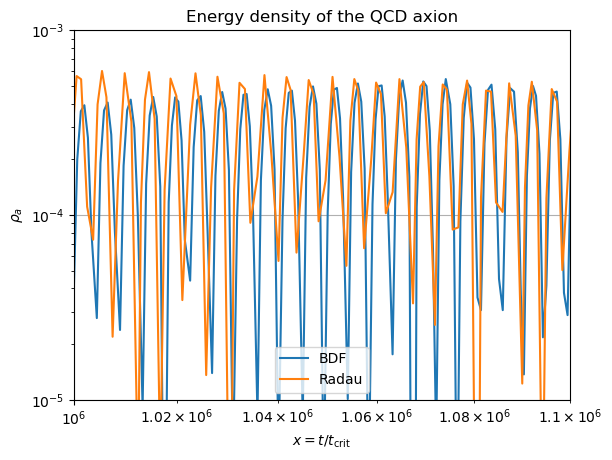

In [552]:
plt.plot(sol1.t, rho_arr1, label=r"BDF")
plt.plot(sol2.t, rho_arr2, label=r"Radau")
plt.xlabel(r"$x = t/t_{\rm crit}$"), plt.xscale('log')
plt.ylabel(r"$\rho_a$"), plt.yscale('log')
plt.xlim(1.e6, 1.1e6), plt.ylim(1.e-5, 1.e-3)
plt.axvline(x=x_osc, color='k', ls='--')
plt.title("Energy density of the QCD axion")
plt.legend()
plt.grid()
plt.show()

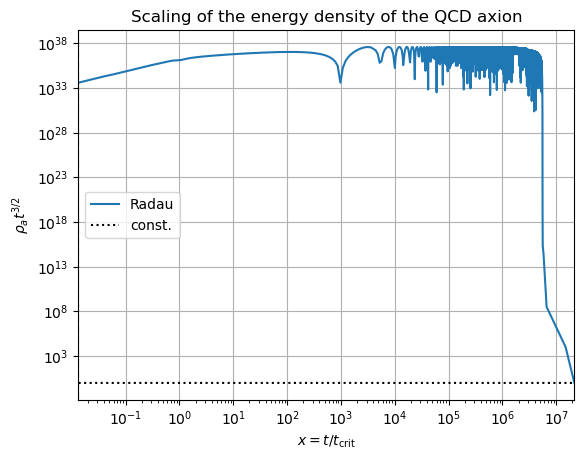

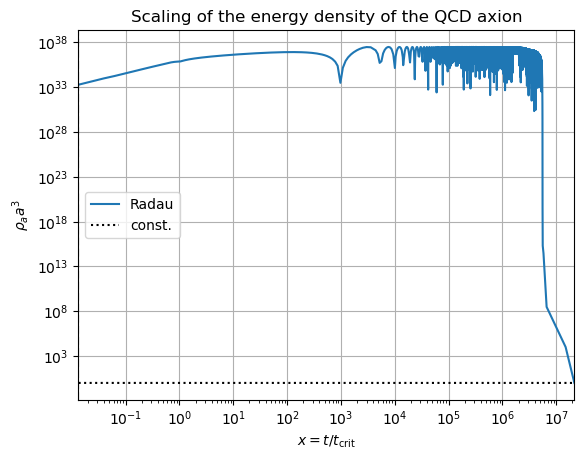

9.056596467094809e-14 4.755992458483257e-09


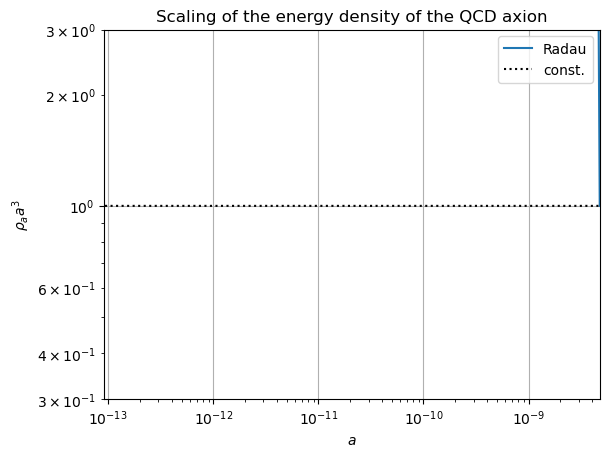

In [553]:
# as a function of t
# plt.plot(sol1.t, (rho_arr1/ rho_arr1[-1])*(sol1.t/sol1.t[-1])**(3/2), label=r"BDF")
plt.plot(sol2.t, (rho_arr2/ rho_arr2[-1])*(sol2.t/sol2.t[-1])**(3/2), label=r"Radau")
# plt.plot(sol3.t, (rho_arr3/ rho_arr3[-1])*(sol3.t/sol3.t[-1])**(3/2), label=r"LSODA")
# plt.plot(sol4.t, (rho_arr4/ rho_arr4[-1])*(sol4.t/sol4.t[-1])**(3/2), label=r"RK45")
plt.plot(sol2.t, np.ones_like(sol2.t), label=r"const.", ls=':', color='k')
plt.xlabel(r"$x = t/t_{\rm crit}$"), plt.xscale('log')
plt.xlim(x_osc, x_span[-1])
plt.ylabel(r"$\rho_a t^{3/2}$"), plt.yscale('log')
# plt.ylim(0.3, 3)
plt.axvline(x=x_osc, color='k', ls='--')
plt.title("Scaling of the energy density of the QCD axion")
plt.legend()
plt.grid()
plt.show()

# as a function of t
# plt.plot(sol1.t, (rho_arr1/ rho_arr1[-1])*(a_arr1/a_arr1[-1])**3, label=r"BDF")
plt.plot(sol2.t, (rho_arr2/ rho_arr2[-1])*(a_arr2/a_arr2[-1])**3, label=r"Radau")
# plt.plot(sol3.t, (rho_arr3/ rho_arr3[-1])*(a_arr3/a_arr3[-1])**(3/2), label=r"LSODA")
# plt.plot(sol4.t, (rho_arr4/ rho_arr4[-1])*(a_arr4/a_arr4[-1])**(3/2), label=r"RK45")
plt.plot(sol2.t, np.ones_like(sol2.t), label=r"const.", ls=':', color='k')
plt.xlabel(r"$x = t/t_{\rm crit}$"), plt.xscale('log')
plt.xlim(x_osc, x_span[-1])
plt.ylabel(r"$\rho_a a^3$"), plt.yscale('log')
# plt.ylim(0.3, 3)
plt.axvline(x=x_osc, color='k', ls='--')
plt.title("Scaling of the energy density of the QCD axion")
plt.legend()
plt.grid()
plt.show()

# as a function of a
# plt.plot(a_arr1, (rho_arr1/ rho_arr1[-1])*(a_arr1/a_arr1[-1])**3, label=r"BDF")
plt.plot(a_arr2, (rho_arr2/ rho_arr2[-1])*(a_arr2/a_arr2[-1])**3, label=r"Radau")
# plt.plot(a_arr3, (rho_arr3/ rho_arr3[-1])*(a_arr3/a_arr3[-1])**(3/2), label=r"LSODA")
# plt.plot(a_arr4, (rho_arr4/ rho_arr4[-1])*(a_arr4/a_arr4[-1])**(3/2), label=r"RK45")
plt.plot(a_arr2, np.ones_like(sol2.t), label=r"const.", ls=':', color='k')
plt.xlabel(r"$a$"), plt.xscale('log')

alo = min([a_arr1[np.argmin(np.abs(x_osc - sol1.t))], a_arr2[np.argmin(np.abs(x_osc - sol2.t))]])
ahi = max([a_arr1[-1], a_arr2[-1]])
print(alo, ahi)

plt.xlim(alo, ahi)
plt.ylabel(r"$\rho_a a^3$"), plt.yscale('log')
plt.ylim(0.3, 3)
# plt.axvline(x=x_osc, color='k', ls='--')
plt.title("Scaling of the energy density of the QCD axion")
plt.legend()
plt.grid()
plt.show()


del alo, ahi

In [554]:
help(axion_abundance)

Help on function axion_abundance in module __main__:

axion_abundance(rho_Arr, x_Arr, xosc)
    axion_abundance : calculate the axion abundance [dimless] today, Omega_a*h^2
    
    Parameters:
    rho_Arr : array of axion energy density values [GeV^4]
    x_Arr : array of times, in units of tcrit [dimless]
    xosc : time at which the last axion oscillation began, in units of tcrit [dimless]
    
    Returns:
    axion_abundance : omega_a = Omega_a * h**2 [dimless]



In [555]:
np.log10((rho_arr2[-1] * a_arr2[-1]**3)/rho_crit / 7.256347455615353 / (h*h))

-21.82804295663154

In [559]:
np.argmin(np.abs(sol2.t - 1.e6))

1647

In [563]:
rho_arr2[1647]*a_arr2[1647]**3 / rho_crit

6226023212462704.0

In [556]:
axion_abundance(rho_arr1, sol1.t, x_osc)

xend= 21782065.881004523
xini= 18480.411101041722 xini_idx= 852
last third= 3.07138743928177
norm_rhoa3= [8.18844317e-02 2.82524590e-02 1.46079301e-03 ... 1.78027999e+01
 7.80671267e+00 1.00000000e+00]
a_Arr= [1.28272787e-10 1.29696975e-10 1.31090765e-10 ... 4.75583683e-09
 4.75592138e-09 4.75599246e-09]
lna_Arr= [-21.11381245 -21.11319821 -21.11252208 ... -19.16389317 -19.16387539
 -19.16386044]
exact norm= 2.3352110955423364


6.282447158414504e+16

In [532]:
np.log10(52706254353503.22)

13.72186215354363

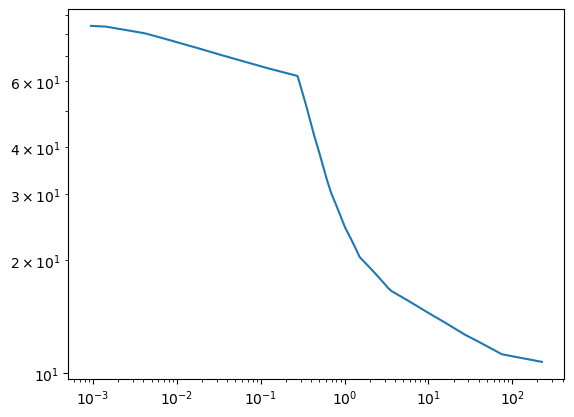

In [231]:
plt.loglog(sol1.t, gs_fn(T_fn(sol1.t*tcrit)))

Clearing definitions

In [ ]:
# del fa_test, epsphi_test, N_test, x_osc, x_span, theta_ini, dtheta_ini, sol1, sol2, temp_arr1, temp_arr2, rho_arr1, rho_arr2, a_arr1, a_arr2